In [1]:
pip install yfinance pandas vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.1 MB/s eta 0:00:00


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [4]:

ticker = "AAPL"
df = yf.download(ticker, start="2023-01-01", end="2024-12-31", auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [5]:

df.reset_index(inplace=True)
df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df.columns]


In [6]:
df.head()

,Date_,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL
0,2023-01-03,123.470627,129.226068,122.582134,128.614001,112117500
1,2023-01-04,124.744118,127.014709,123.480487,125.267339,89113600
2,2023-01-05,123.421249,126.136083,123.164580,125.504267,80962700
3,2023-01-06,127.962425,128.623856,123.292916,124.398597,87754700
4,2023-01-09,128.485641,131.703962,128.228972,128.801557,70790800


In [7]:

if 'Adj Close' in df.columns:
    df.rename(columns={'Adj Close': 'Close'}, inplace=True)
elif 'Close_AAPL' in df.columns:
    df.rename(columns={'Close_AAPL': 'Close'}, inplace=True)


In [9]:
df['Date_'] = pd.to_datetime(df['Date_'])

In [10]:
df.head()

,Date_,Close,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL
0,2023-01-03,123.470627,129.226068,122.582134,128.614001,112117500
1,2023-01-04,124.744118,127.014709,123.480487,125.267339,89113600
2,2023-01-05,123.421249,126.136083,123.164580,125.504267,80962700
3,2023-01-06,127.962425,128.623856,123.292916,124.398597,87754700
4,2023-01-09,128.485641,131.703962,128.228972,128.801557,70790800


In [11]:

news_data = {
    'Date': ['2023-01-03', '2023-01-04', '2023-01-05'],
    'Headline': [
        'Apple releases new iPhone model',
        'Stock markets tumble after inflation news',
        'Strong demand boosts Apple sales forecast'
    ]
}

In [12]:
news_df = pd.DataFrame(news_data)
news_df['Date'] = pd.to_datetime(news_df['Date'])



In [13]:
analyzer = SentimentIntensityAnalyzer()
news_df['Sentiment'] = news_df['Headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])


In [14]:
sentiment_df = news_df.groupby('Date')['Sentiment'].mean().reset_index()
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])


In [18]:
print(df.columns)


Index(['Date_', 'Close', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL'], dtype='object')


In [19]:

df.rename(columns={'Date_': 'Date'}, inplace=True)


In [20]:
merged_df = pd.merge(df, sentiment_df, on='Date', how='left')
merged_df['Sentiment'] = merged_df['Sentiment'].fillna(0)


In [21]:
df.columns

Index(['Date', 'Close', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL'], dtype='object')

In [22]:

merged_df.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in merged_df.columns]


In [23]:

for col in merged_df.columns:
    if "Close" in col and col != "Close":
        merged_df.rename(columns={col: "Close"}, inplace=True)

In [24]:
df.columns

Index(['Date', 'Close', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL'], dtype='object')

In [25]:

data = merged_df[['Close', 'Sentiment']].copy()
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


In [26]:
X, y = [], []
sequence_length = 60

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, 0])  # Predict 'Close'

X, y = np.array(X), np.array(y)

In [27]:

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=10, batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0849
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0114
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0069
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0073
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0049
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0051
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0050
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0050
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0050
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0049


In [28]:

last_60_days = scaled_data[-60:]
pred_input = np.expand_dims(last_60_days, axis=0)

pred_scaled = model.predict(pred_input)
pred_price = scaler.inverse_transform([[pred_scaled[0][0], 0]])[0][0]

print("\n✅ Prediction Complete!")
print("📅 Next Day Predicted Closing Price:", f"${pred_price:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step

✅ Prediction Complete!
📅 Next Day Predicted Closing Price: $250.56


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


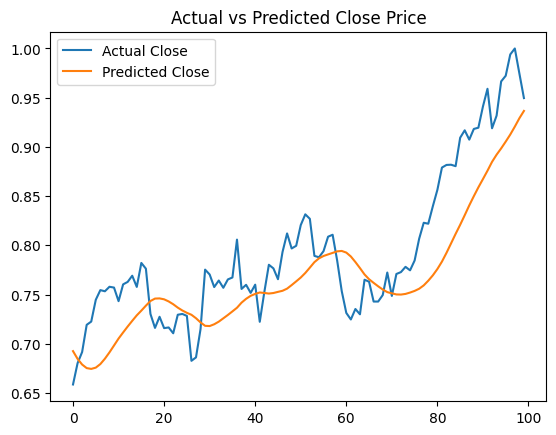

In [29]:

plt.plot(y[-100:], label="Actual Close")
plt.plot(model.predict(X[-100:]), label="Predicted Close")
plt.title("Actual vs Predicted Close Price")
plt.legend()
plt.show()

In [32]:
# Get last prediction date from merged_df
last_date = merged_df['Date'].max()


In [33]:
# Download next day's actual price
next_day = last_date + pd.Timedelta(days=1)
next_day_end = last_date + pd.Timedelta(days=2)
actual_df = yf.download(ticker, start=next_day, end=next_day_end, auto_adjust=True)


[*********************100%***********************]  1 of 1 completed


In [34]:

if 'Adj Close' in actual_df.columns:
    actual_price = actual_df['Adj Close'].values[0]
else:
    actual_price = actual_df['Close'].values[0]

In [36]:

print(f"\n📅 Last date in training: {last_date.date()}")
print(f"📈 Predicted Next Day Price: ${pred_price:.2f}")
print(f"📊 Actual Next Day Price   : ${actual_price[0]:.2f}")


📅 Last date in training: 2024-12-30
📈 Predicted Next Day Price: $250.56
📊 Actual Next Day Price   : $249.82


In [37]:

predicted_prices = model.predict(X[-100:])
true_prices = y[-100:]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [38]:
# Inverse transform both to original scale
inv_pred = scaler.inverse_transform(np.hstack([predicted_prices, np.zeros((len(predicted_prices), 1))]))[:, 0]
inv_true = scaler.inverse_transform(np.hstack([true_prices.reshape(-1, 1), np.zeros((len(true_prices), 1))]))[:, 0]



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


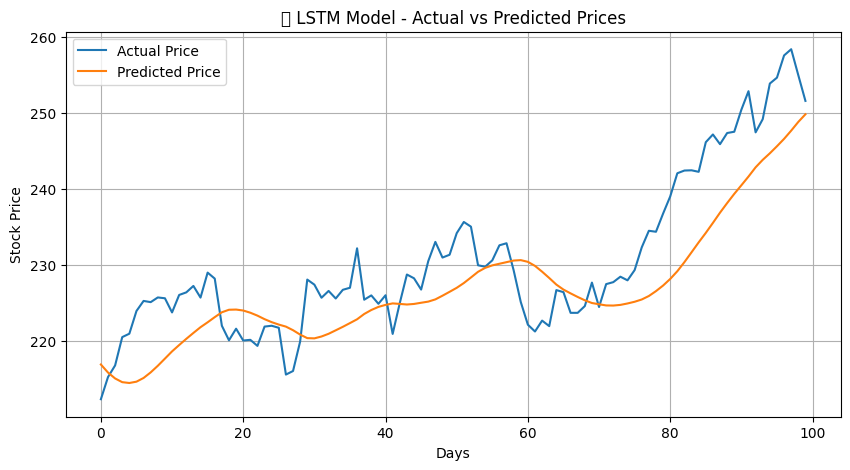

In [39]:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(inv_true, label="Actual Price")
plt.plot(inv_pred, label="Predicted Price")
plt.title("📈 LSTM Model - Actual vs Predicted Prices")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()


In [40]:
mae = mean_absolute_error(inv_true, inv_pred)
rmse = np.sqrt(mean_squared_error(inv_true, inv_pred))

print(f"\n📏 Mean Absolute Error (MAE): {mae:.2f}")
print(f"📏 Root Mean Squared Error (RMSE): {rmse:.2f}")


📏 Mean Absolute Error (MAE): 5.38
📏 Root Mean Squared Error (RMSE): 6.36


In [41]:
# Save the trained model
model.save("stock_lstm_model.h5")
print("✅ Model saved as 'stock_lstm_model.h5'")


✅ Model saved as 'stock_lstm_model.h5'


In [42]:
import joblib

# Save the fitted MinMaxScaler
joblib.dump(scaler, "scaler.pkl")
print("✅ Scaler saved as 'scaler.pkl'")


✅ Scaler saved as 'scaler.pkl'
